In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "KoddiUD 온고딕"
    }
</style>

In [2]:
# 라이브러리 로드
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [3]:
# 한글 폰트 설정

# pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

# 0. 분석 목표 & 데이터 불러오기

- 배경
  - 회사의 규모 성장을 위해 단기적인 현금 보유가 필요
  - 현재 서비스에서 제공하고 있는 멤버십 옵션
    - 1개월
    - 12개월
  - **C레벨들은 12개월 단위로 결제하는 구독자의 비율을 늘린다면 단기적으로 현금 흐름이 개선될 것을 기대**
    - &rarr; 멤버십 결제 페이지 개선
      - 멤버십 옵션을 사용자에게 제시
        - &rarr; 12개월 멤버십의 구독 비율 높이기
- 실험 개요
  - A안(기존안)
    - 1개월 및 12개월 멤버십 가격 단순 비교
      ![기존안](https://bakey-api.codeit.kr/api/files/resource?root=static&seqId=10722&version=2&directory=/plan_A.png&name=plan_A.png)
  - B안(변경안)
    - 12개월 멤버십의 월간 가격을 강조하여, 더 경제적인 선택이라는 점 부각
      ![변경안](https://bakey-api.codeit.kr/api/files/resource?root=static&seqId=10722&version=2&directory=/plan_B.png&name=plan_B.png)

- 실험 가설
  - 12개월 멤버십의 월간 가격을 보여줌으로써, 사용자들이 더 경제적인 12개월 멤버십을 선택할 가능성이 높아질 것이다.
- 기존 지표
  - A안(기존안) 
    - 1개월 구독 비율: 83%
    - 12개월 구독 비율: 17%
- 데이터 개요
  - 30일 동안 일별 데이터 수집
    - 페이지 방문자 수
    - 구독 전환율
      - 페이지 방문자 중 실제 구독을 완료한 비율
    - 구독자 수 
      - 1개월 및 12개월 구독자 수
    - 수익
      - 각 실험안에서 발생한 총 수익
- 실험 기간
  - 2023.09.15 ~ 2023.10.14(30일)

In [4]:
df = pd.read_csv('subscription.csv')
df.head()


,Unnamed: 0,Date,Total Users,Subscribers,1-Month Subscribers,12-Month Subscribers,Revenue,Group,Conversion Rate,1-Month Revenue,12-Month Revenue
0,0,2023.9.15,459,22,19,3,1547,A,0.047930,665,882
1,1,2023.9.16,504,26,21,5,2205,A,0.051587,735,1470
2,2,2023.9.17,514,26,22,4,1946,A,0.050584,770,1176
3,3,2023.9.18,482,23,19,4,1841,A,0.047718,665,1176
4,4,2023.9.19,512,25,19,6,2429,A,0.048828,665,1764


| 컬럼명                | 설명                                           |
|-----------------------|----------------------------------------------|
| Unnamed: 0           | 인덱스 (0 - 29)                                     |
| Date                 | 날짜                                            |
| Total Users          | 총 사용자 수                      |
| Subscribers          | 총 구독자 수           |
| 1-Month Subscribers  | 1개월 구독자 수                          |
| 12-Month Subscribers | 12개월 구독자 수                           |
| Revenue              | 총 매출액          |
| Group                | 실험 그룹(A: control 그룹, B: test 그룹)                   |
| Conversion Rate      | 전환율(사용자에서 구독자로 전환한 수 / 총 사용자 수) |
| 1-Month Revenue      | 1개월 구독 매출
| 12-Month Revenue     | 12개월 구독 매출        |

# 1. 데이터 살펴보기

In [5]:
# Unnamed: 0은 index값이기 때문에 제거해도 무방
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  60 non-null     object 
 1   Total Users           60 non-null     int64  
 2   Subscribers           60 non-null     int64  
 3   1-Month Subscribers   60 non-null     int64  
 4   12-Month Subscribers  60 non-null     int64  
 5   Revenue               60 non-null     int64  
 6   Group                 60 non-null     object 
 7   Conversion Rate       60 non-null     float64
 8   1-Month Revenue       60 non-null     int64  
 9   12-Month Revenue      60 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 4.8+ KB


In [7]:
df.describe(include='all')

,Date,Total Users,Subscribers,1-Month Subscribers,12-Month Subscribers,Revenue,Group,Conversion Rate,1-Month Revenue,12-Month Revenue
count,60,60.000000,60.000000,60.000000,60.000000,60.000000,60,60.000000,60.000000,60.00000
unique,30,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,2023.9.15,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN
mean,NaN,507.450000,29.666667,24.183333,5.483333,2458.516667,NaN,0.058497,846.416667,1612.10000
std,NaN,42.213109,5.697655,4.515479,2.062512,687.849917,NaN,0.010425,158.041755,606.37846
min,NaN,424.000000,20.000000,17.000000,2.000000,1323.000000,NaN,0.044944,595.000000,588.00000
25%,NaN,480.500000,25.000000,20.000000,4.000000,1867.250000,NaN,0.048701,700.000000,1176.00000
50%,NaN,512.000000,30.000000,24.000000,5.000000,2415.000000,NaN,0.055037,840.000000,1470.00000
75%,NaN,528.750000,35.000000,28.000000,7.000000,2924.250000,NaN,0.068341,980.000000,2058.00000


# 2. 전처리

## 2.1 날짜 datetime 형식 변환

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

## 2.2 A안과 B안 그룹 분할

- 앞선 `.describe()` 살펴본 결과 두 집단 각각 30명으로 크기 동일

In [9]:
# A안과 B안 데이터 분리
df_A = df[df['Group'] == 'A']
df_B = df[df['Group'] == 'B']

# 3. 데이터 살펴보기

- 일반적으로 샘플 크기가 30을 넘으면 충분히 큰 샘플 크기로 간주하고 Z-score로 계산
  - 지금 데이터에서는 샘플 크기 각 30으로 경계에 있어 T-분포 사용

In [10]:
df_A.describe()

,Date,Total Users,Subscribers,1-Month Subscribers,12-Month Subscribers,Revenue,Conversion Rate,1-Month Revenue,12-Month Revenue
count,30,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2023-09-29 12:00:00,508.833333,24.766667,20.500000,4.266667,1971.900000,0.048621,717.500000,1254.400000
min,2023-09-15 00:00:00,431.000000,20.000000,17.000000,2.000000,1323.000000,0.044944,595.000000,588.000000
25%,2023-09-22 06:00:00,477.500000,23.000000,19.000000,3.000000,1695.750000,0.046779,665.000000,882.000000
50%,2023-09-29 12:00:00,512.000000,25.000000,20.000000,4.000000,1876.000000,0.048574,700.000000,1176.000000
75%,2023-10-06 18:00:00,530.250000,26.000000,22.000000,5.000000,2205.000000,0.050659,770.000000,1470.000000
max,2023-10-14 00:00:00,607.000000,31.000000,24.000000,8.000000,3157.000000,0.051724,840.000000,2352.000000
std,NaN,44.581644,2.712466,1.995685,1.387961,431.619193,0.002077,69.848975,408.060645


In [11]:
df_B.describe()

,Date,Total Users,Subscribers,1-Month Subscribers,12-Month Subscribers,Revenue,Conversion Rate,1-Month Revenue,12-Month Revenue
count,30,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2023-09-29 12:00:00,506.066667,34.566667,27.866667,6.700000,2945.133333,0.068373,975.333333,1969.800000
min,2023-09-15 00:00:00,424.000000,29.000000,22.000000,2.000000,1813.000000,0.058350,770.000000,588.000000
25%,2023-09-22 06:00:00,484.250000,32.250000,26.000000,6.000000,2647.750000,0.065807,910.000000,1764.000000
50%,2023-09-29 12:00:00,513.500000,35.000000,28.000000,7.000000,2891.000000,0.068360,980.000000,2058.000000
75%,2023-10-06 18:00:00,527.250000,36.750000,29.000000,8.000000,3297.000000,0.070470,1015.000000,2352.000000
max,2023-10-14 00:00:00,577.000000,39.000000,35.000000,11.000000,4214.000000,0.077381,1225.000000,3234.000000
std,NaN,40.421003,3.002107,3.070812,1.914554,535.137993,0.003874,107.478413,562.878893


## 3.1 Impression(Total Users) 분석

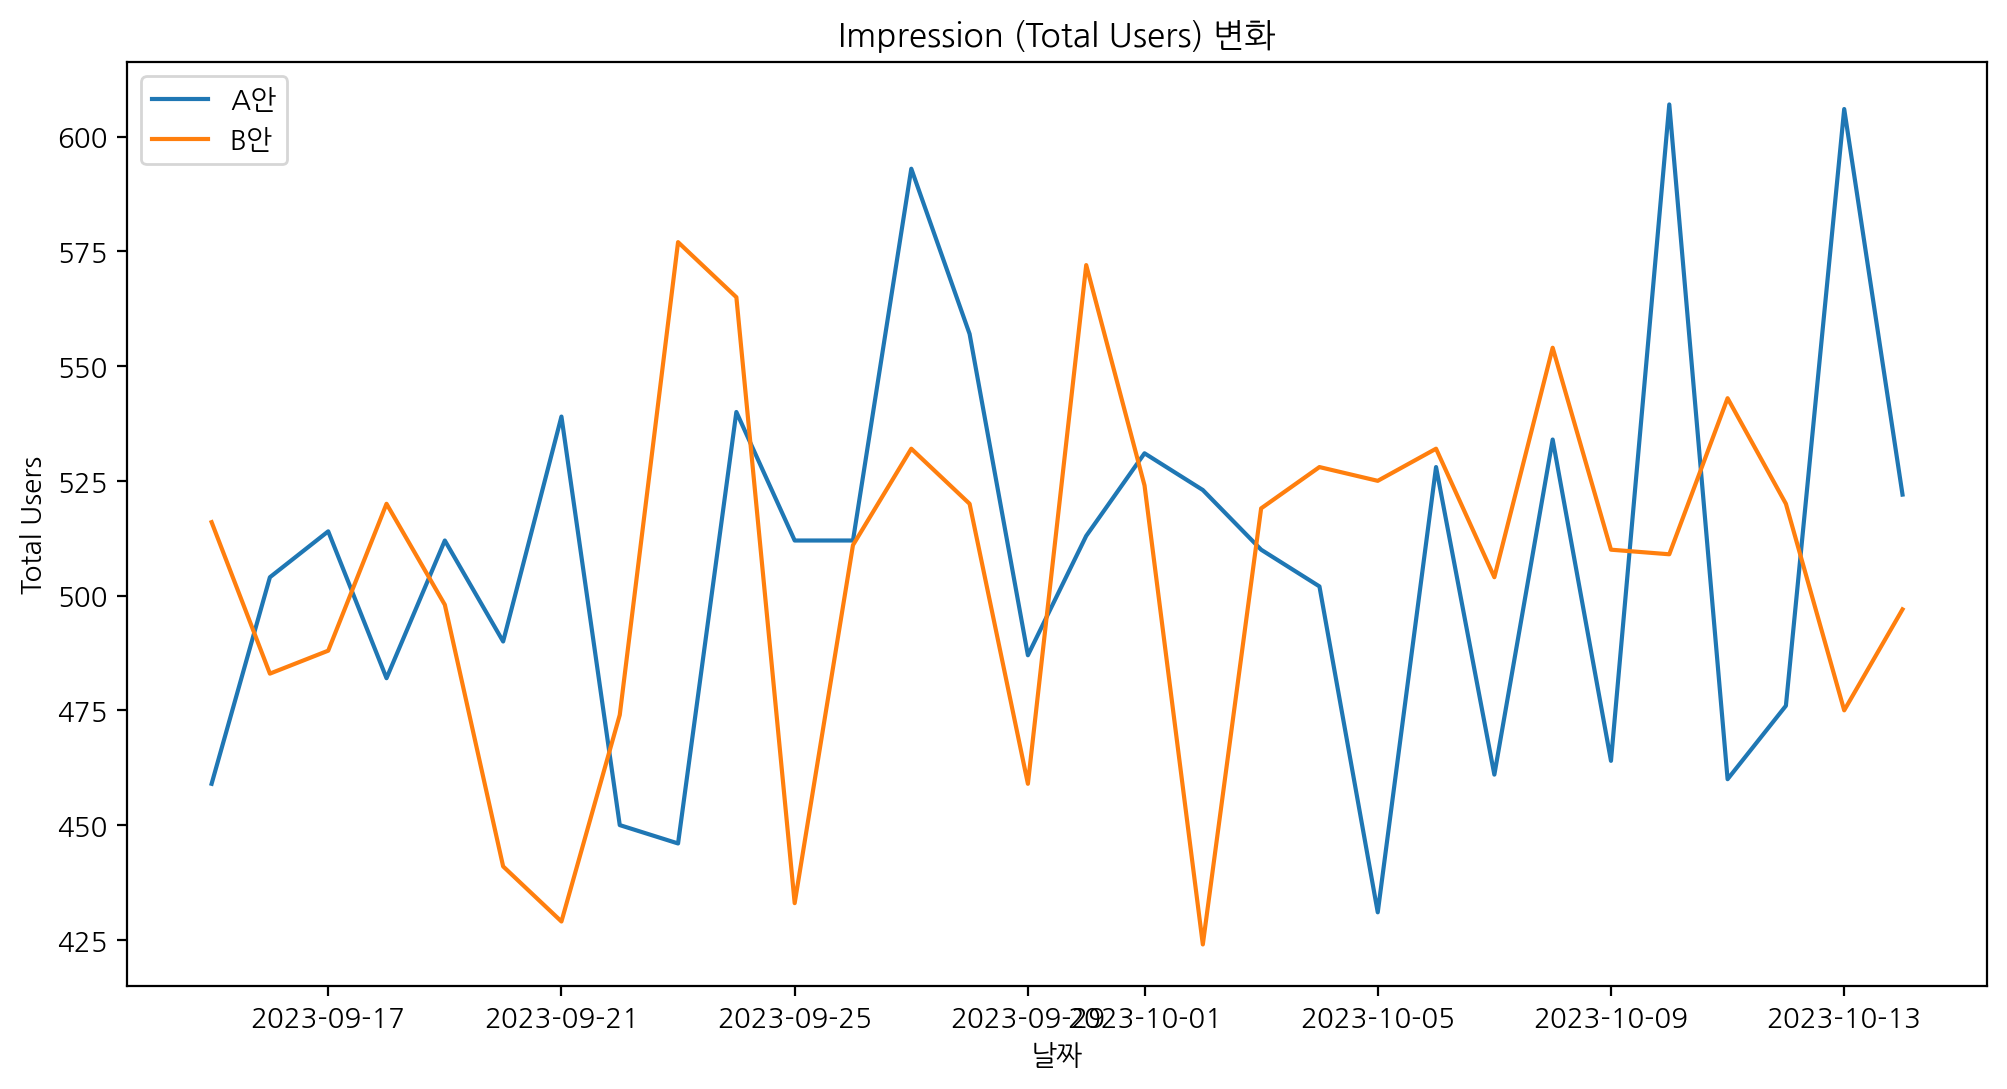

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df_A['Date'], df_A['Total Users'], label='A안')
plt.plot(df_B['Date'], df_B['Total Users'], label='B안')
plt.title('Impression (Total Users) 변화')
plt.xlabel('날짜')
plt.ylabel('Total Users')
plt.legend()
plt.show()

In [13]:
t_stat, p_value = stats.ttest_ind(df_A['Total Users'], df_B['Total Users'])
print(f'Impression t-test 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

Impression t-test 결과: t-statistic = 0.2518, p-value = 0.8021


**[분석 결과]**
- 그룹에 따라 사용자 수(가입자 수)에는 차이가 없음
- t-test결과 p-value값이 약 0.8021로 통계적 유의미한 차이도 없는 것으로 판단됨

## 3.2 Revenue/Conversion Rate 분석

### 1) 그룹별 수익(Revenue)에는 차이가 있을 것이다.

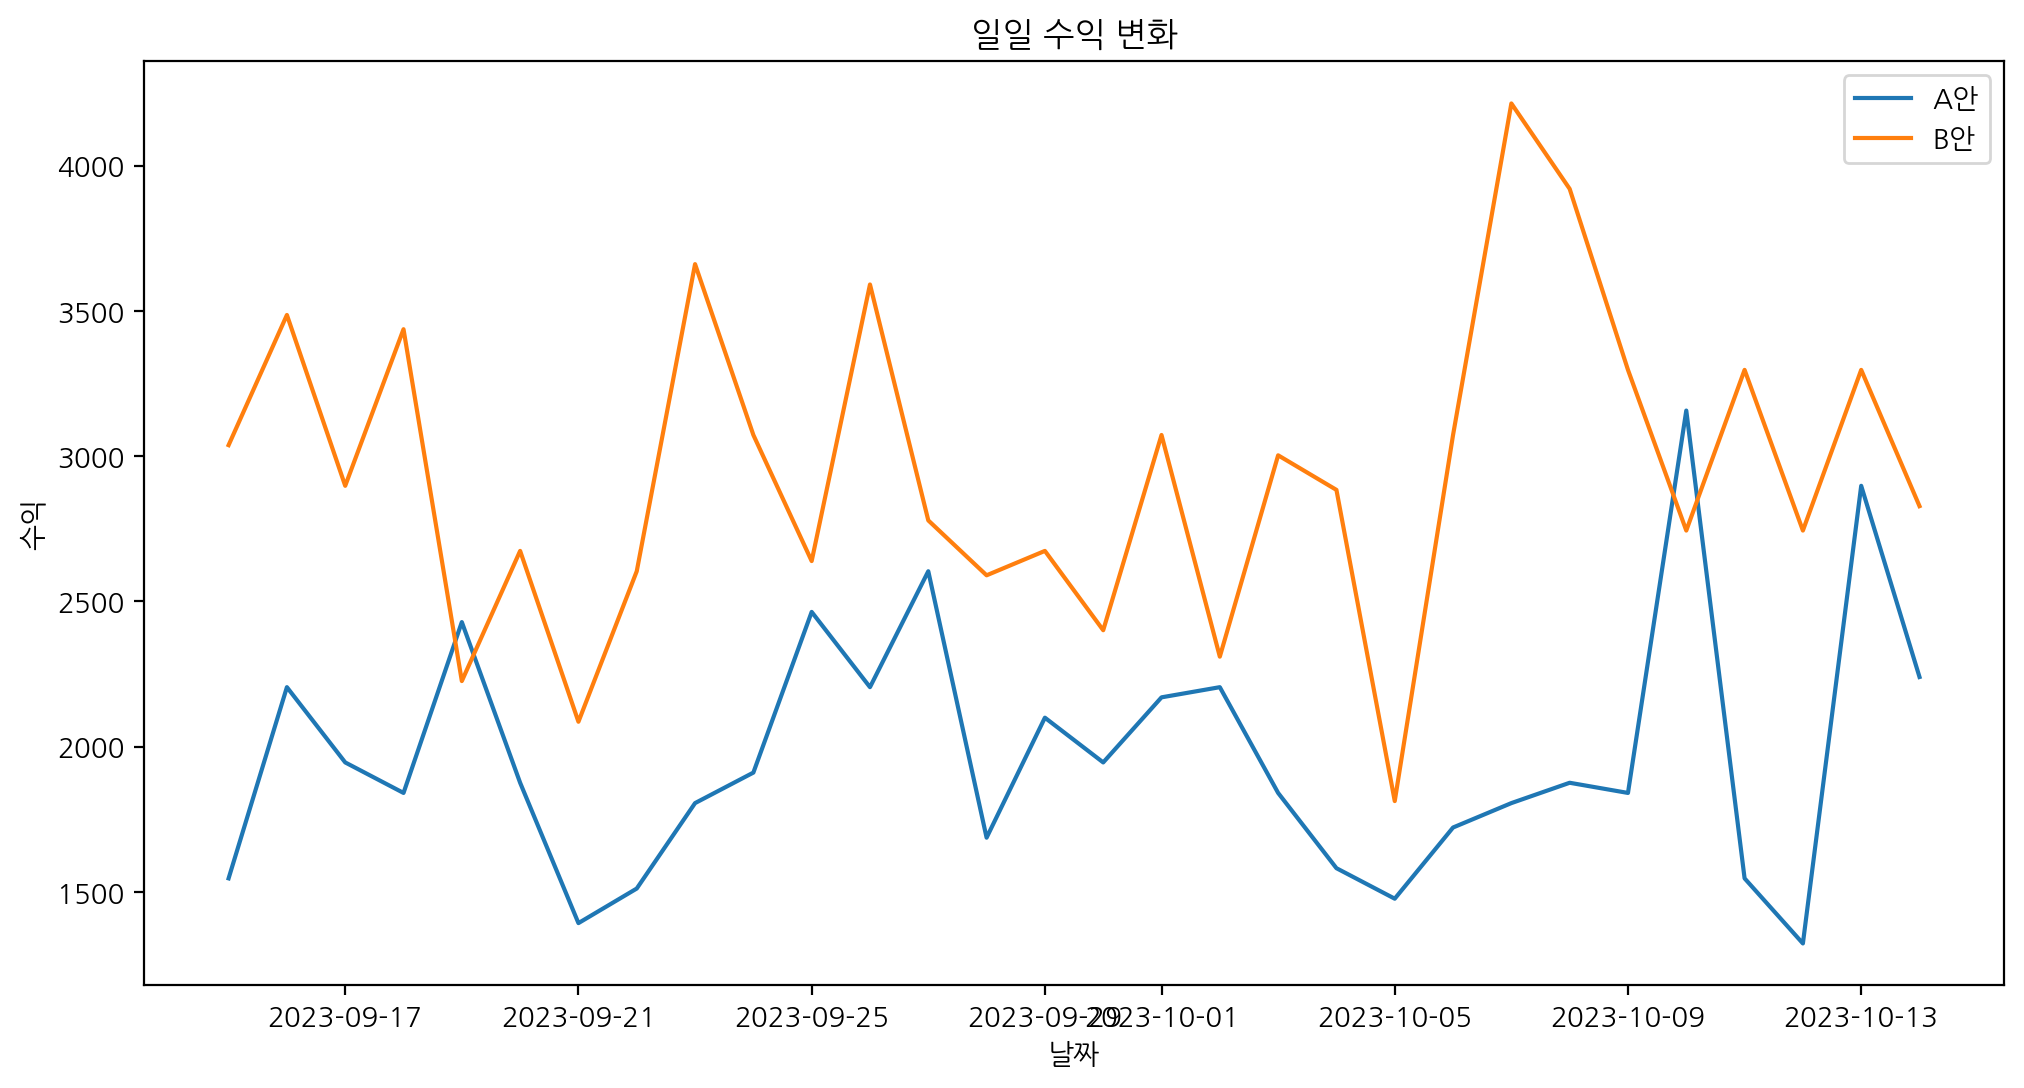

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df_A['Date'], df_A['Revenue'], label='A안')
plt.plot(df_B['Date'], df_B['Revenue'], label='B안')
plt.title('일일 수익 변화')
plt.xlabel('날짜')
plt.ylabel('수익')
plt.legend()
plt.show()

In [15]:
# t-test 수행
t_stat, p_value = stats.ttest_ind(df_A['Revenue'], df_B['Revenue'])
print(f'수익 t-test 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

수익 t-test 결과: t-statistic = -7.7535, p-value = 0.0000


**[분석 결과]**
- 수익 측면에서도 B안이 A안보다 우수한 성과를 보임
  - A 그룹의 평균 수익 1971.90
  - B 그룹의 평균 수익 2945.13
- t-test결과 통계적 유의미한 차이도 존재

### 2) 그룹별 전환율(Conversion Rate)에는 차이가 있을 것이다.

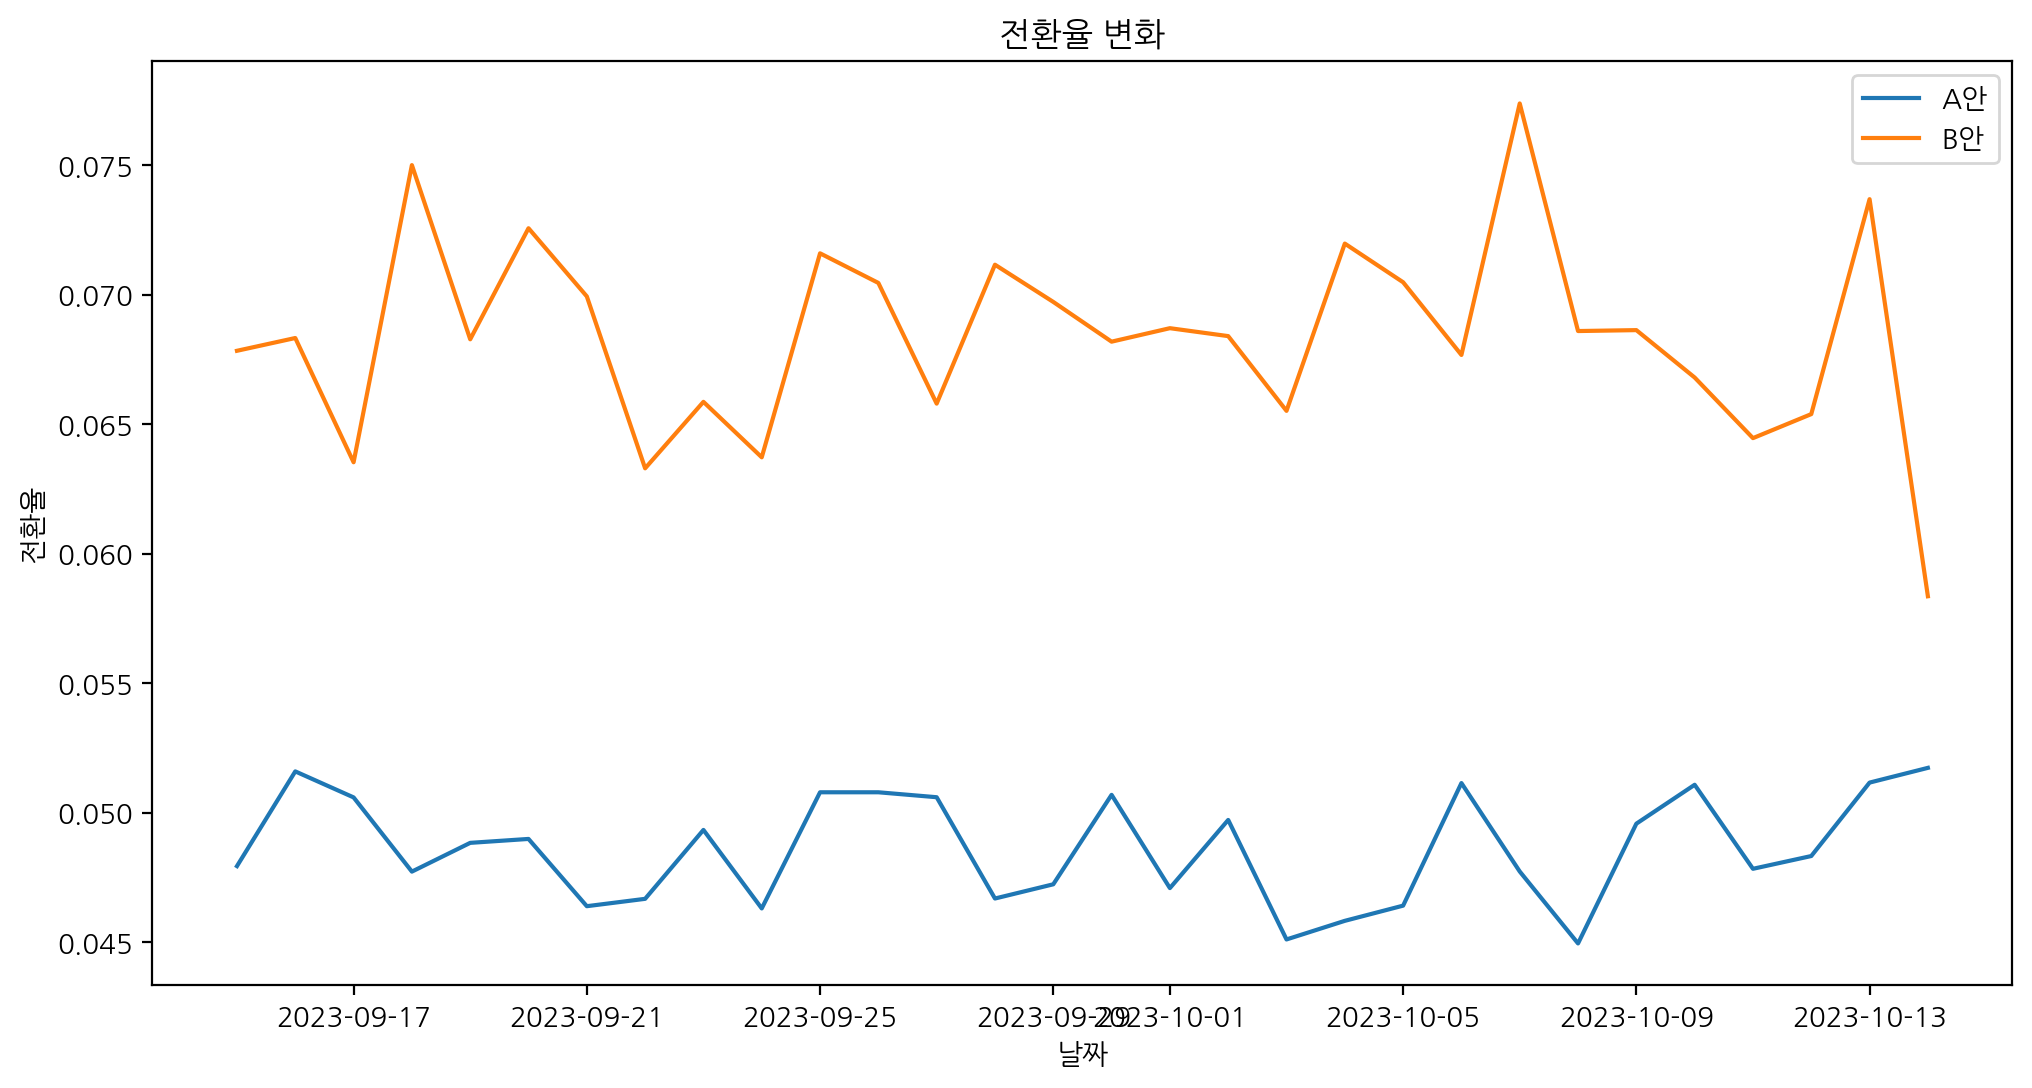

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_A['Date'], df_A['Conversion Rate'], label='A안')
plt.plot(df_B['Date'], df_B['Conversion Rate'], label='B안')
plt.title('전환율 변화')
plt.xlabel('날짜')
plt.ylabel('전환율')
plt.legend()
plt.show()

In [17]:
t_stat, p_value = stats.ttest_ind(df_A['Conversion Rate'], df_B['Conversion Rate'])
print(f'전환율 t-test 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

전환율 t-test 결과: t-statistic = -24.6107, p-value = 0.0000


**[분석 결과]**
- A 그룹의 평균 전환율 약 4.86%
- B 그룹의 평균 전환율 약 6.84%
- t-test결과 통계적 유의미한 차이도 존재
- &rarr; B안이 사용자를 구독자로 전환시키는 데 더 효과적임

## 3.3 1-Month와 12-Month 분석

### 1) 그룹별 1개월 구독자 수에는 차이가 있을 것이다.

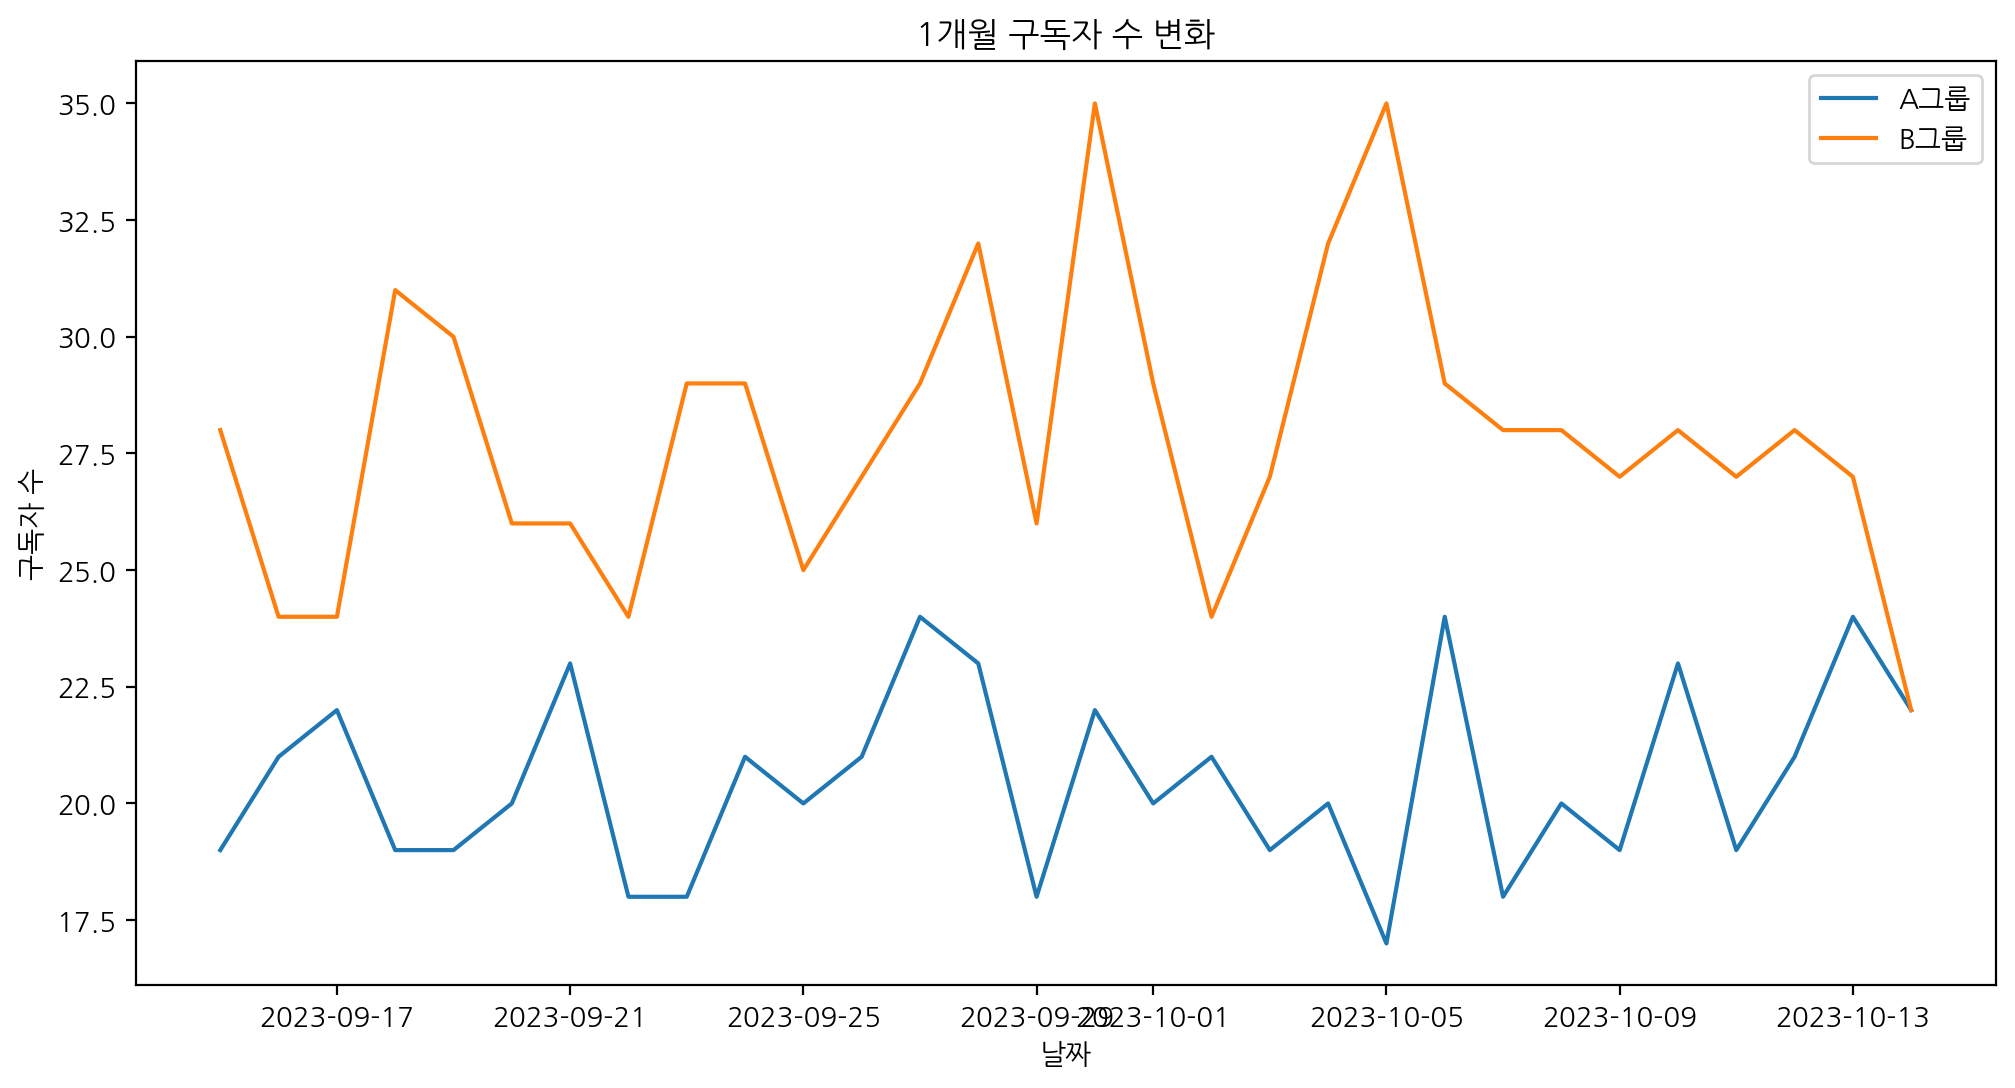

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df_A['Date'], df_A['1-Month Subscribers'], label='A그룹')
plt.plot(df_B['Date'], df_B['1-Month Subscribers'], label='B그룹')
plt.title('1개월 구독자 수 변화')
plt.xlabel('날짜')
plt.ylabel('구독자 수')
plt.legend()
plt.show()

In [19]:
# t-test 수행
t_stat, p_value = stats.ttest_ind(df_A['1-Month Subscribers'], df_B['1-Month Subscribers'])
print(f'1개월 구독자 수 t-test 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

1개월 구독자 수 t-test 결과: t-statistic = -11.0173, p-value = 0.0000


**[분석 결과]**
- B 그룹의 1개월 구독자 수가 A 그룹보다 높은 추세를 보임
- t-test 결과 p-value가 0.05보다 작아 두 그룹 사이 통계적으로 유의미한 차이가 있다고 할 수 있음

### 2) 그룹별 12개월 구독자 수에는 차이가 있을 것이다.

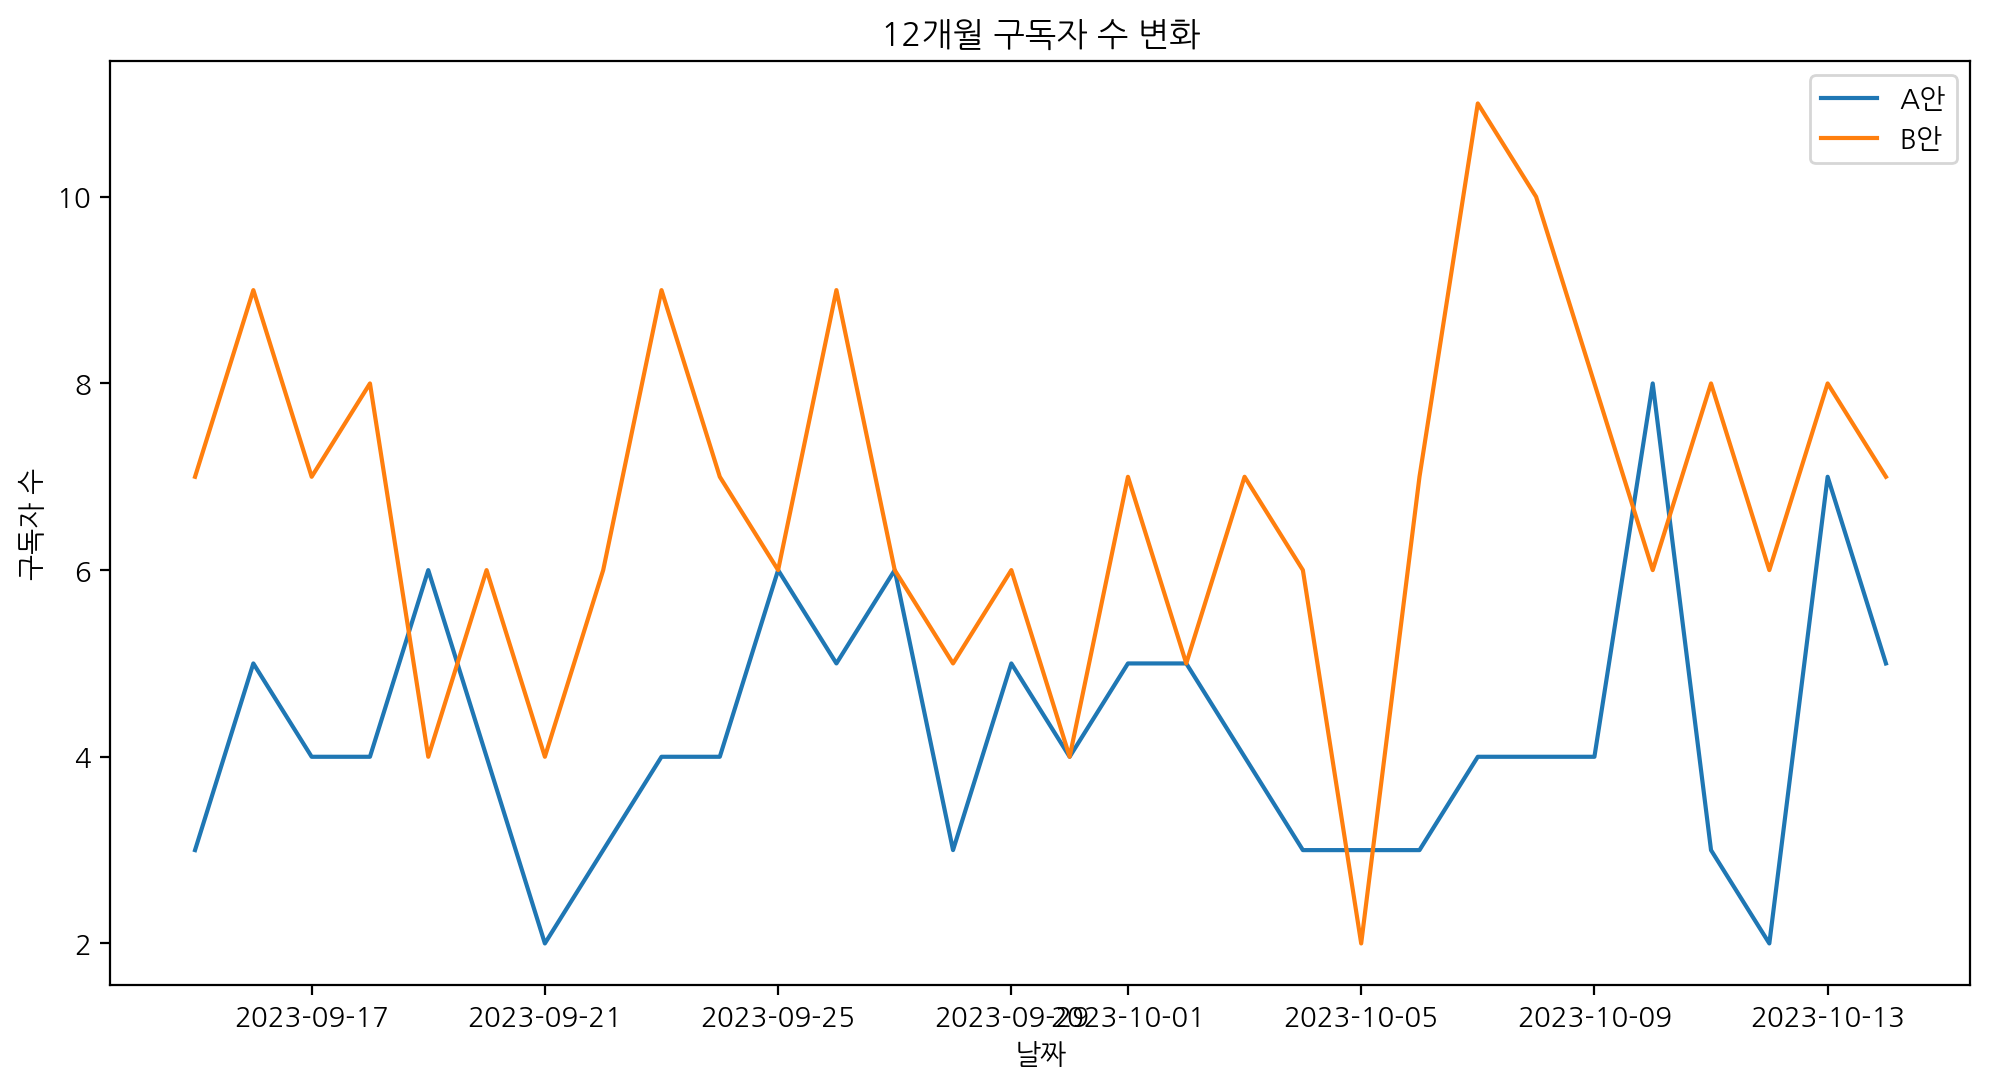

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df_A['Date'], df_A['12-Month Subscribers'], label='A안')
plt.plot(df_B['Date'], df_B['12-Month Subscribers'], label='B안')
plt.title('12개월 구독자 수 변화')
plt.xlabel('날짜')
plt.ylabel('구독자 수')
plt.legend()
plt.show()

In [21]:
# t-test 수행
t_stat, p_value = stats.ttest_ind(df_A['12-Month Subscribers'], df_B['12-Month Subscribers'])
print(f'12개월 구독자 수 t-test 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

12개월 구독자 수 t-test 결과: t-statistic = -5.6361, p-value = 0.0000


**[분석 결과]**
  - 12개월 구독자 수도 B안에서 더 높은 추세를 보임
  - t-test 결과 통계적 유의미한 차이 존재

### 3) 그룹별 12개월 구독율에는 차이가 있을 것이다.

In [22]:
df_A['12-Month Subscription Rate'] = (df_A['12-Month Subscribers']/df_A['Subscribers'])*100
df_B['12-Month Subscription Rate'] = (df_B['12-Month Subscribers']/df_B['Subscribers'])*100
df_B.head()

,Date,Total Users,Subscribers,1-Month Subscribers,12-Month Subscribers,Revenue,Group,Conversion Rate,1-Month Revenue,12-Month Revenue,12-Month Subscription Rate
30,2023-09-15,516,35,28,7,3038,B,0.067829,980,2058,20.000000
31,2023-09-16,483,33,24,9,3486,B,0.068323,840,2646,27.272727
32,2023-09-17,488,31,24,7,2898,B,0.063525,840,2058,22.580645
33,2023-09-18,520,39,31,8,3437,B,0.075000,1085,2352,20.512821
34,2023-09-19,498,34,30,4,2226,B,0.068273,1050,1176,11.764706


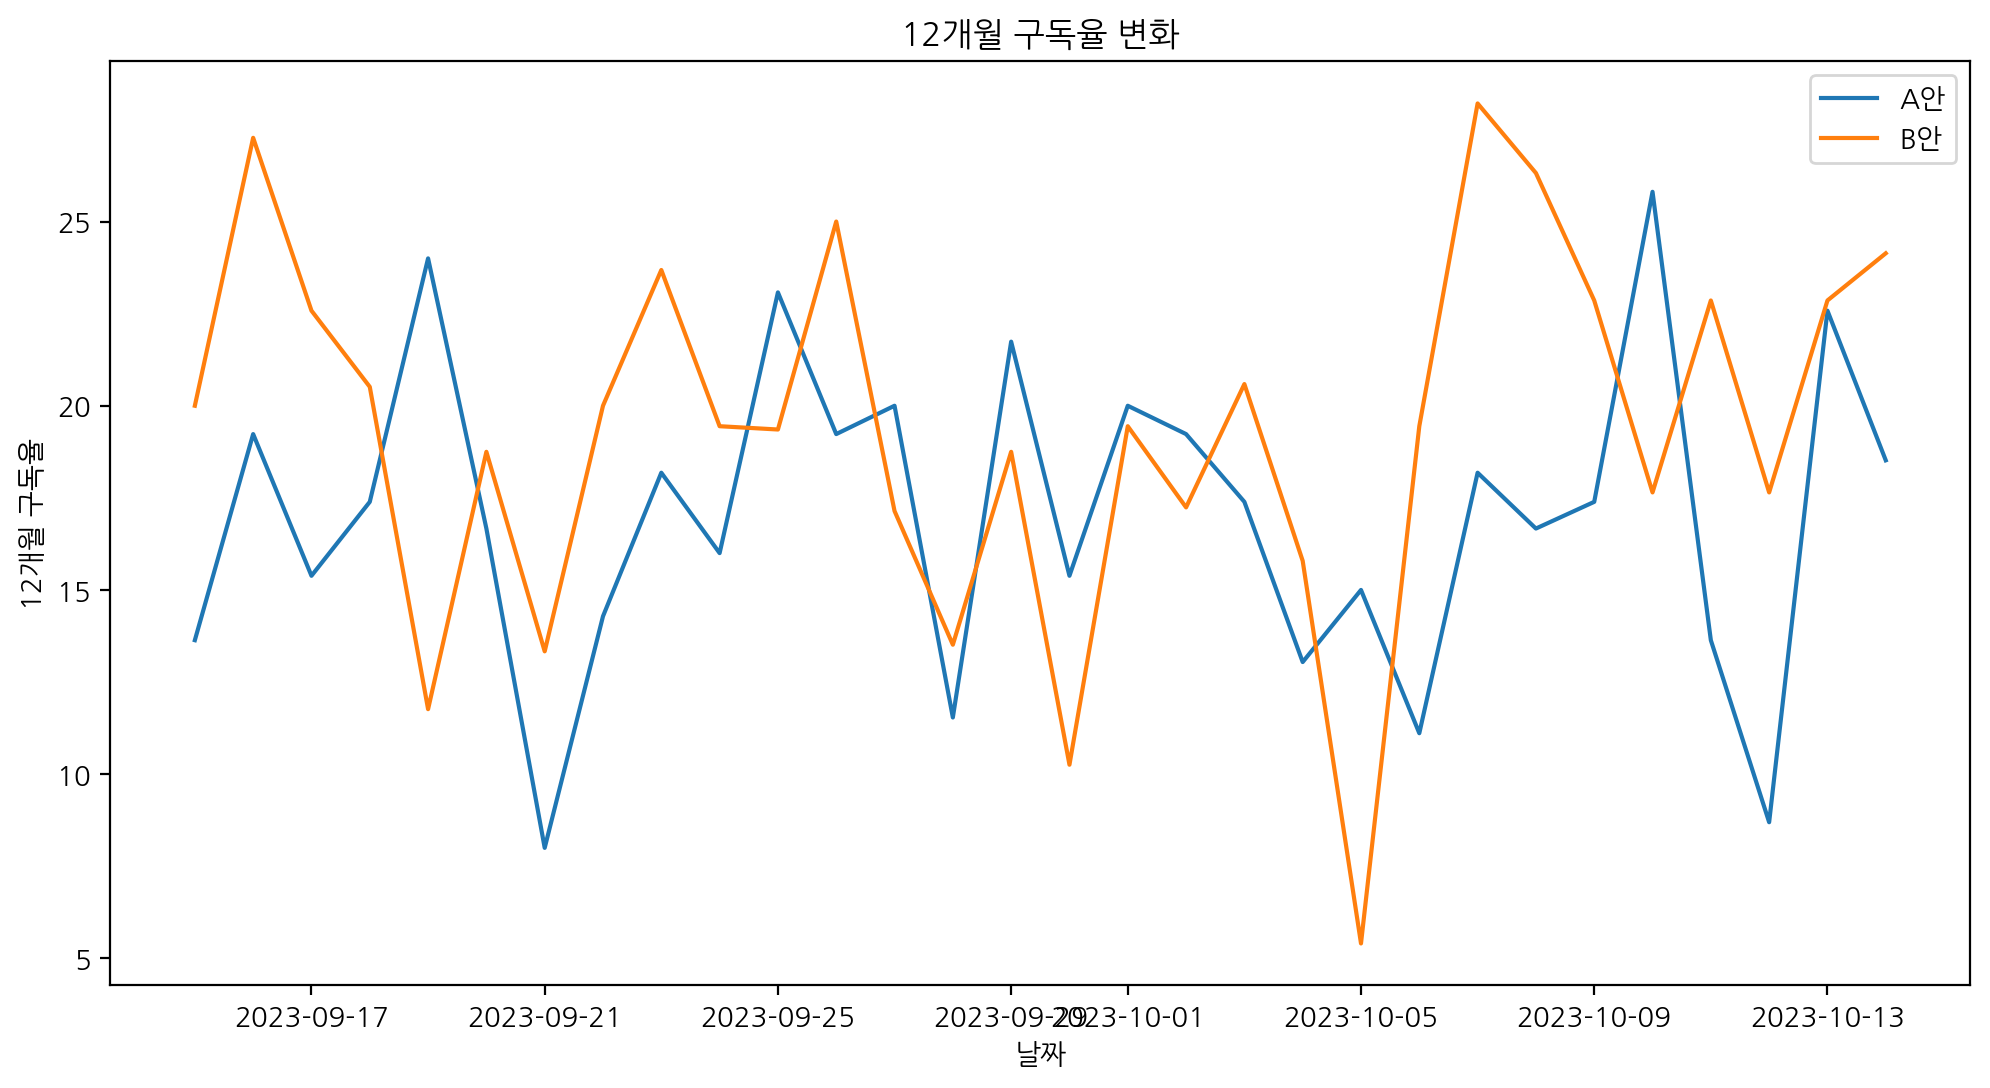

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df_A['Date'], df_A['12-Month Subscription Rate'], label='A안')
plt.plot(df_B['Date'], df_B['12-Month Subscription Rate'], label='B안')
plt.title('12개월 구독율 변화')
plt.xlabel('날짜')
plt.ylabel('12개월 구독율')
plt.legend()
plt.show()

In [24]:
# t-test 수행
t_stat, p_value = stats.ttest_ind(df_A['12-Month Subscription Rate'], df_B['12-Month Subscription Rate'])
print(f'12개월 구독자 수 t-test 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

12개월 구독자 수 t-test 결과: t-statistic = -1.9502, p-value = 0.0560


**[분석결과]**
- A와 B 그룹 사이의 차이가 크지 않음
- t-test 결과 p-value 0.0560으로 일반적으로 사용되는 유의 수준인 0.05보다 약간 높음
  - 두 그룹 간 차이가 통계적으로 유의미하다고 말하기엔 부족

# 4. 분석결과 종합

- B안이 A안보다 더 높은 수익을 창출
  - 더 높은 1개월과 12개월 구독자 수
- 하지만 Impression(신규 사용자)와 전체 구독자 중 12개월 구독자 비율에서는 A와 B 그룹 사이 유의미한 차이가 나타나지 않음
- &rArr; 신규 사용자는 이번 실험 관련 직접적 지표는 아니지만, 12개월 구독자 비율은 더 높길 기대했던 핵심 지표
  - 하지만, 실험 결과 전체적인 구독자 수는 증가했으나 12개월 구독자의 비율은 크게 증가하지 않음
    - &rArr; 추가적으로 12개월 구독율을 높이기 위한 다른 방안 도출 후 재실험 필요함